# Chapter 18 - Reinforcement Learning

In Reinforcement Learning, a software *agent* makes observations and takes actions within an *environment*, and in return it receives *rewards*. Its objective is to learn to act in a way that will maximize its expected rewards over time

## Policy Search

The algorithm a software agent uses to determine its actions is called its *policy*. There are some example of policy search:

1. Use a *brute force* approach to find the best policy parameters that maximize reward.
2. Use *genetic algorithms* and iterate through generation of policies until you find a good policy.
3. Use *policy gradients* by evaluating the gradients of the rewards with regard to the policy parameters.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# To get smooth animations
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')


## Introduction to OpenAI Gym

One of the greatest challenges when training RL algoritms is that we need to have an environment where the agent can take actions. For that, we can use the OpenAI Gym, which is a toolkit that provides a wide variety of simulated environments (Atari games, board games, 2D and 3D physical simulations, and so on), so you can train agents, compare them, or develop new RL algorithms.

In [2]:
import gym
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([ 0.03574043, -0.04664144,  0.02296554, -0.03243444], dtype=float32)

Here, we’ve created a CartPole environment. This is a 2D simulation in which a cart can be accelerated left or right in order to balance a pole placed on top of it (see Figure 18-4).

![Cart Pole](./images/ch18_cart_pole.png)

In [3]:
# get a list of all available environments
# gym.envs.registry.all()

For the CartPole environment, each observation is a 1D NumPy array containing four floats, these floats
represent:

1. the cart’s horizontal position (0.0 = center)
2. its velocity (positive means right)
3. the angle of the pole (0.0 = vertical)
4. and its angular velocity (positive means clockwise).

In [4]:
# render the environment
# env.render()

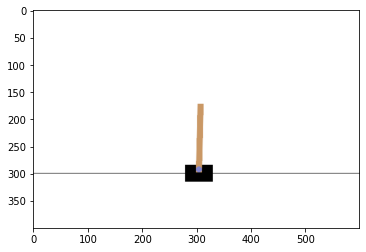

In [3]:
img = env.render(mode="rgb_array")
img.shape # height, width, channels (3 = Red, Green, Blue)

In [4]:
# set of possible actions
env.action_space

Discrete(2)

`Discrete(2)` means that the possible actions are integers 0 and 1, which represent accelerating left (0) or right (1). Other environments may have additional discrete actions, or other kinds of actions (e.g., continuous). Since the pole is leaning toward the right (`obs[2] > 0`), let’s accelerate the cart toward the right:

In [5]:
action = 1
obs, reward, done, info = env.step(action)

In [8]:
obs

array([ 0.0348076 ,  0.14814377,  0.02231686, -0.31778395], dtype=float32)

In [6]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(1):
    episode_rewards = 0
    obs = env.reset(seed=42)
    for step in range(200):
        img = env.render(mode="rgb_array")
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

In [11]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(55.0, 0.0, 55.0, 55.0)

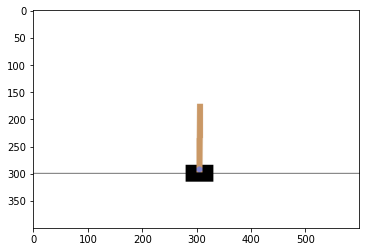

In [13]:
env_screen = env.render(mode="rgb_array")
plt.imshow(env_screen) # height, width, channels (3 = Red, Green, Blue)

## Neural Network Policies

Let’s create a neural network policy. Just like with the policy we hardcoded
earlier, this neural network will take an observation as input, and it will output
the action to be executed. It will output the probability $p$ of action 0 (left), and of course the probability of
action 1 (right) will be $1 – p$. 

In [8]:
import tensorflow as tf
from tensorflow import keras

n_inputs = 4 # == env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[n_inputs]),
    keras.layers.Dense(1, activation="sigmoid")
])

2022-06-06 10:33:58.962772: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-06 10:33:58.962809: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-06 10:33:58.962836: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alexandre-Inspiron-5458): /proc/driver/nvidia/version does not exist
2022-06-06 10:33:58.973742: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


How do we train this network?

## Evaluating Actions: The Credit Assignment Problem

If the agent manages to balance the pole for 100 steps,
how can it know which of the 100 actions it took were good, and which of them
were bad? All it knows is that the pole fell after the last action, but surely this
last action is not entirely responsible. This is called the credit assignment
problem: when the agent gets a reward, it is hard for it to know which actions
should get credited (or blamed) for it.

To deal with it, a common strategy is to evaluate an action based on the sum of all the rewards that come after it, usually applying a discount factor $\gamma$ at each step.  This sum of discounted rewards is called the action's return. If an agent decides to go right three times in a row and gets +10 reward after the first step, 0 after the second step, and finally –50 after the third step, then assuming we use a discount factor $\gamma = 0.8$, the first action will have a return of $10 + \gamma × 0 + \gamma^2 × (–50) = –22$.

Now that we have a way to evaluate each action, we are ready to train our first agent using policy gradients.
Let’s see how.

## Plotting animations

In [15]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [16]:
frames = render_policy_net(model)
plot_animation(frames)

## Policy Gradients

In [17]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [18]:
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [19]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_rate = 0.95

In [20]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [21]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])

In [22]:
env = gym.make("CartPole-v1")
env.seed(42);

for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

/home/alexandre/git/handson-ml-notes/env-handsonml/lib/python3.8/site-packages/gym/core.py:200: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Iteration: 149, mean rewards: 178.4

In [23]:
frames = render_policy_net(model)
plot_animation(frames)